# Xiezhenghang-二号策略（一号策略改进版本）

策略逻辑：设定唐安奇通道上线，为50分钟收盘最大值，当分钟的最大值突破上一分钟通道的上线1.01倍时认为有上涨趋势并做多，分钟最小值突破上线0.99倍且上一分钟是在上线之上时判断有下跌趋势并做空（若有仓位，突破时平仓，并且反向开仓）。

在一号的海龟策略基础上，增加了仓位管理操作，利用ATR判断波动率，波动率小的时候重仓，波动率大的时候弱仓。

In [1]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME

# 创建回测引擎对象
engine = BacktestingEngine()
# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
engine.setStartDate('20170703',initDays=1)               # 设置回测用的数据起始日期
engine.setEndDate('20180820')
# 配置回测引擎参数
engine.setSlippage(0.1)     # 设置滑点为股指1跳
engine.setRate(1/1000)   # 设置手续费千1
engine.setSize(1)         # 设置合约大小 
engine.setPriceTick(0.1)    # 设置股指最小价格变动   
engine.setCapital(100000)  # 设置回测本金

In [11]:
from __future__ import division

from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarGenerator,
                                                     ArrayManager)
import talib as ta
########################################################################
# 策略继承CtaTemplate
class SuiBianXieDe(CtaTemplate):
    #单边海龟策略+波动率仓位管理
    className = 'SuiBianXieDe'
    author = 'ZhenghangXie'
    
    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    posDict = {}  # 初始化仓位字典
    
    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位
    storage = EMPTY_STRING


    initDays = 1       # 初始化数据所用的天数  
    stopRatio = 0.06   # 止损比例
    fixsize = 1
    
        # 策略变量
    transactionPrice = EMPTY_FLOAT # 记录成交价格

    
    ##########
    
        # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'symbolList',
                'stopRatio']    
    
    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
              'transactionPrice',
              'maTrend']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict']
    
    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super(SuiBianXieDe, self).__init__(ctaEngine, setting)
        
        # 给多空仓位命名
        symbol = self.symbolList[0]
        self.Longpos = symbol.replace('.','_')+"_LONG"
        self.Shortpos = symbol.replace('.','_')+"_SHORT"
        
        self.bg15 = BarGenerator(self.onBar, 15, self.on15MinBar)
        self.bg15Dict = {
            sym: self.bg15
            for sym in self.symbolList
        }


         #生成Bar数组
        self.am15Dict = {
            sym: ArrayManager(size=100)
            for sym in self.symbolList
        }    
            
            
        self.amDict = {
            sym: ArrayManager(size=100)
            for sym in self.symbolList
        }
        
        self.am15Dict = {
            sym: ArrayManager(size=100)
            for sym in self.symbolList
        }        
        
        

      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'海龟策略初始化')
        # 初始化仓位字典
        self.ctaEngine.initPosition(self)
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)
        
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'海龟策略初始化')
        #print('start',file=test)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'海龟策略初始化')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
        
    def on15MinBar(self, bar):
        """15分钟K线推送"""
        symbol = bar.vtSymbol
        am15 = self.am15Dict[symbol]
        am15.updateBar(bar)
        
        if not am15.inited:
            return
        
        #仓位管理
        self.ATR = ta.ATR(am15.high,am15.low,am15.close,6)
        if self.ATR[-1] < 8 :
            self.storage = 5
        elif self.ATR[-1] < 40:
            self.storage = 4
        elif self.ATR[-1] < 80 :
            self.storage = 3
        elif self.ATR[-1] < 300 :
            self.storage = 1
        elif self.ATR[-1] >= 300 :
            self.storage = 0
            
#         self.VAR = ta.VAR(am15.close,15,1)
#         if self.VAR[-1] < 1000:
#             self.storage = 5
#         elif self.VAR[-1] < 40000:
#             self.storage = 3
#         elif self.VAR[-1] < 100000:
#             self.storage = 1
#         elif self.VAR[-1] >=100000:
#             self.storage = 0
        
            

        
    
        
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll() # 全部撤单
        symbol = bar.vtSymbol
        
        bg15 = self.bg15Dict[symbol]
        bg15.updateBar(bar)
        
        
        # 洗价器（止损止盈）
        if (self.posDict[self.Longpos] > 0):
            if (bar.close<self.transactionPrice*(1-self.stopRatio)) or (bar.close>self.transactionPrice*(1+2*self.stopRatio)):
                self.cancelAll()
                self.sell(symbol,bar.close, self.posDict[self.Longpos])
                #print('止盈止损','time:%s,atr:%s,storage:%s'%(bar.datetime,self.ATR[-1],self.storage),file = test0)
        elif (self.posDict[self.Shortpos] > 0):
            if (bar.close>self.transactionPrice*(1+self.stopRatio)) or  (bar.close<self.transactionPrice*(1-2*self.stopRatio)):
                self.cancelAll()
                self.cover(symbol,bar.close, self.posDict[self.Shortpos])
                #rint('止盈止损','time:%s,atr:%s,storage:%s'%(bar.datetime,self.ATR[-1],self.storage),file=test0)
        self.amDict[symbol].updateBar(bar)
        am = self.amDict[symbol]
        if not am.inited:
            return
        ######### 计算策略需要的信号-------------------------------------------------####################################        
        
        Shortmax = ta.MAX(am.high,timeperiod=50)        
        self.amclose0 = am.close[-1]
        self.amclose1 = am.close[-2]
        self.signal0 = Shortmax[-2]
        self.signal1 = Shortmax[-3]
        
        
        if self.amclose0 >= 1.01*self.signal0 and  self.amclose1 < self.signal1:
            self.Cross = 1
        elif self.amclose0 <= 0.99*self.signal0 and  self.amclose1 > self.signal1:
            self.Cross = -1 
        else:
            self.Cross = 0
            
        


        if self.Cross == 1:
            # 如果无持仓，突破短期上限则直接做多
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                #print('signal',self.signal,file = test)
                #print('time:%s,amclose0:%s, amclose1:%s, smax0:%s, smax1:%s'%(bar.datetime,self.amclose0,self.amclose1,self.smax0,self.smax1),file=test)
                #print('正常开多仓','time:%s,storage:%s'%(bar.datetime,self.storage),file=test0)
                self.buy(symbol,bar.close, self.storage*self.fixsize)                
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[self.Shortpos]>0 :
                self.cover(symbol,bar.close, self.posDict[self.Shortpos])
                self.buy(symbol,bar.close, self.storage*self.fixsize)
                #print('正常交易，先平空仓后买多空','time:%s,storage:%s'%(bar.datetime,self.storage),file=test0)
                #print('signal',self.signal,file = test)
                #print('time:%s,amclose0:%s, amclose1:%s, smax0:%s, smax1:%s'%(bar.datetime,self.amclose0,self.amclose1,self.smax0,self.smax1),file=test)
        # 突破下线则相反，多头持仓先卖掉多头再卖空
        elif self.Cross == -1:
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                
               #print('正常开空仓','time:%s,storage:%s'%(bar.datetime,self.storage),file=test0)
                #print('signal',self.signal,file = test)
                #print('time:%s,amclose0:%s, amclose1:%s, smin0:%s, smin1:%s'%(bar.datetime,self.amclose0,self.amclose1,self.smin0,self.smin1),file=test)
                self.short(symbol,bar.close,self.storage*self.fixsize)
            elif self.posDict[self.Longpos] > 0:
                self.sell(symbol,bar.close, self.posDict[self.Longpos])
                self.short(symbol,bar.close,self.storage*self.fixsize)
                #print('正常交易，先平多仓后卖空','time:%s,storage:%s'%(bar.datetime,self.storage),file=test0)
                #print('signal',self.signal,file = test)
                #print('time:%s,amclose0:%s, amclose1:%s, smin0:%s, smin1:%s'%(bar.datetime,self.amclose0,self.amclose1,self.smin0,self.smin1),file=test)
         
        # 发出状态更新事件
        self.putEvent()
        
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        self.transactionPrice = trade.price
        #print('price:%s, direction:%s,offset:%s,self.Cross:%s,tradeVolume: %s'
                #%(trade.price, trade.direction, trade.offset,self.Cross,trade.volume),file=test0)
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [12]:
# 在引擎中创建策略对象
test0 = open('test0.txt','w')
d = {'ShortWindow': 20 , 'symbolList':['tBTCUSD:bitfinex']}                    # 策略参数配置
engine.initStrategy(SuiBianXieDe, d)    # 创建策略对象
engine.runBacktesting()
test0.close()

2018-09-06 16:07:23.715214	开始回测
2018-09-06 16:07:23.716214	策略初始化
2018-09-06 16:07:23.716214	载入历史数据。数据范围:[20170702,20170703)
2018-09-06 16:07:23.894224	载入完成，数据量：1409
2018-09-06 16:07:23.926226	策略初始化完成
2018-09-06 16:07:23.926226	策略启动完成
2018-09-06 16:07:23.926226	开始回放回测数据,回测范围:[20170703,20180821)
2018-09-06 16:07:23.929226	载入历史数据。数据范围:[20170703,20180821)
2018-09-06 16:08:47.482005	载入完成，数据量：634244
2018-09-06 16:08:47.483005	当前回放数据:[20170703,20180821)
2018-09-06 16:09:03.845941	数据回放结束ss: 100%    


In [ ]:
# 显示前10条成交记录
for i in range(100):
    d = engine.tradeDict[str(i+1)].__dict__
    print('TradeID: %s, Time: %s, Direction: %s, Price: %s, Volume: %s' %(d['tradeID'], d['dt'], d['direction'], d['price'], d['volume']))

2018-09-06 16:04:25.251007	计算按日统计结果
2018-09-06 16:04:25.315010	------------------------------
2018-09-06 16:04:25.316010	首个交易日：	2017-07-03
2018-09-06 16:04:25.316010	最后交易日：	2018-08-20
2018-09-06 16:04:25.316010	总交易日：	414
2018-09-06 16:04:25.316010	盈利交易日	91
2018-09-06 16:04:25.316010	亏损交易日：	65
2018-09-06 16:04:25.316010	起始资金：	100000
2018-09-06 16:04:25.316010	结束资金：	128,897.73
2018-09-06 16:04:25.316010	总收益率：	28.9%
2018-09-06 16:04:25.316010	年化收益：	16.75%
2018-09-06 16:04:25.316010	总盈亏：	28,897.73
2018-09-06 16:04:25.316010	最大回撤: 	-5,695.91
2018-09-06 16:04:25.316010	百分比最大回撤: -5.46%
2018-09-06 16:04:25.316010	总手续费：	1,738.37
2018-09-06 16:04:25.316010	总滑点：	24.1
2018-09-06 16:04:25.317010	总成交金额：	1,738,368.25
2018-09-06 16:04:25.318010	总成交笔数：	149
2018-09-06 16:04:25.318010	日均盈亏：	69.8
2018-09-06 16:04:25.318010	日均手续费：	4.2
2018-09-06 16:04:25.318010	日均滑点：	0.06
2018-09-06 16:04:25.318010	日均成交金额：	4,198.96
2018-09-06 16:04:25.318010	日均成交笔数：	0.36
2018-09-06 16:04:25.318010	日均收益率：	0.06%
2018-09-06 1

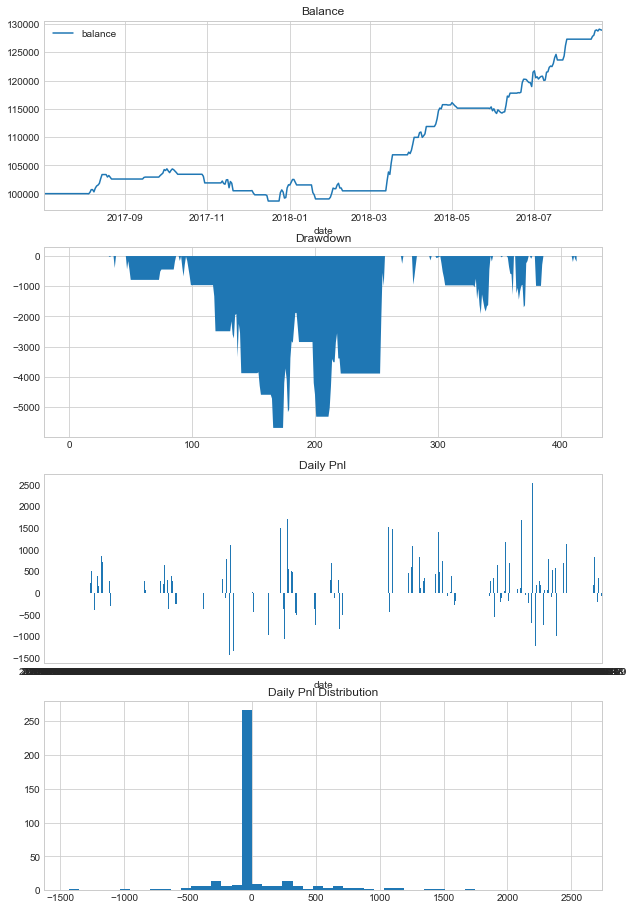

2018-09-06 16:04:29.030223	计算回测结果
2018-09-06 16:04:29.046224	------------------------------
2018-09-06 16:04:29.047224	第一笔交易：	2017-08-12 05:12:00
2018-09-06 16:04:29.047224	最后一笔交易：	2018-08-20 23:59:00
2018-09-06 16:04:29.047224	总交易次数：	88
2018-09-06 16:04:29.047224	总盈亏：	28,878.15
2018-09-06 16:04:29.047224	最大回撤: 	-5,871.36
2018-09-06 16:04:29.047224	平均每笔盈利：	328.16
2018-09-06 16:04:29.047224	平均每笔滑点：	0.28
2018-09-06 16:04:29.047224	平均每笔佣金：	19.97
2018-09-06 16:04:29.047224	胜率		65.91%
2018-09-06 16:04:29.048224	盈利交易平均值	827.81
2018-09-06 16:04:29.048224	亏损交易平均值	-637.83
2018-09-06 16:04:29.048224	盈亏比：	1.3


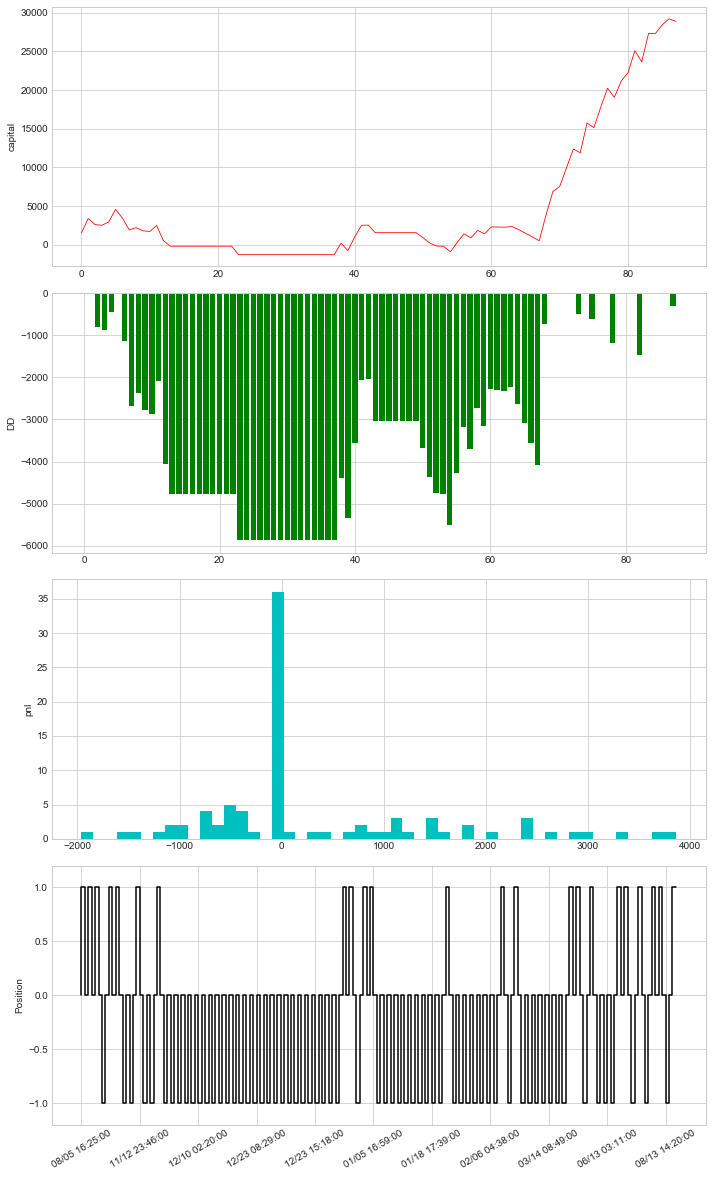

In [9]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()


2018-08-25 11:38:21.350068	计算按日统计结果
2018-08-25 11:38:21.412072	------------------------------
2018-08-25 11:38:21.412072	首个交易日：	2017-07-01
2018-08-25 11:38:21.412072	最后交易日：	2018-08-20
2018-08-25 11:38:21.413072	总交易日：	416
2018-08-25 11:38:21.413072	盈利交易日	91
2018-08-25 11:38:21.413072	亏损交易日：	65
2018-08-25 11:38:21.413072	起始资金：	100000
2018-08-25 11:38:21.413072	结束资金：	128,897.73
2018-08-25 11:38:21.413072	总收益率：	28.9%
2018-08-25 11:38:21.413072	年化收益：	16.67%
2018-08-25 11:38:21.413072	总盈亏：	28,897.73
2018-08-25 11:38:21.413072	最大回撤: 	-5,695.91
2018-08-25 11:38:21.413072	百分比最大回撤: -5.46%
2018-08-25 11:38:21.413072	总手续费：	1,738.37
2018-08-25 11:38:21.413072	总滑点：	24.1
2018-08-25 11:38:21.413072	总成交金额：	1,738,368.25
2018-08-25 11:38:21.413072	总成交笔数：	149
2018-08-25 11:38:21.413072	日均盈亏：	69.47
2018-08-25 11:38:21.413072	日均手续费：	4.18
2018-08-25 11:38:21.414072	日均滑点：	0.06
2018-08-25 11:38:21.414072	日均成交金额：	4,178.77
2018-08-25 11:38:21.414072	日均成交笔数：	0.36
2018-08-25 11:38:21.414072	日均收益率：	0.06%
2018-08-25

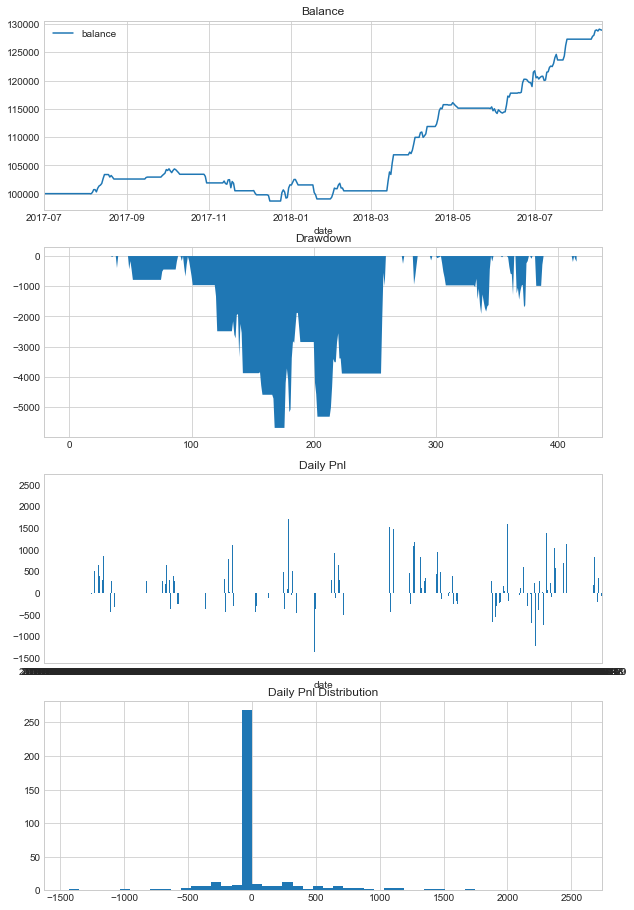

2018-08-25 11:38:25.967332	计算回测结果
2018-08-25 11:38:25.979333	------------------------------
2018-08-25 11:38:25.980333	第一笔交易：	2017-08-12 05:12:00
2018-08-25 11:38:25.980333	最后一笔交易：	2018-08-20 23:59:00
2018-08-25 11:38:25.981333	总交易次数：	88
2018-08-25 11:38:25.981333	总盈亏：	28,878.15
2018-08-25 11:38:25.981333	最大回撤: 	-5,871.36
2018-08-25 11:38:25.981333	平均每笔盈利：	328.16
2018-08-25 11:38:25.981333	平均每笔滑点：	0.28
2018-08-25 11:38:25.981333	平均每笔佣金：	19.97
2018-08-25 11:38:25.981333	胜率		65.91%
2018-08-25 11:38:25.981333	盈利交易平均值	827.81
2018-08-25 11:38:25.981333	亏损交易平均值	-637.83
2018-08-25 11:38:25.981333	盈亏比：	1.3


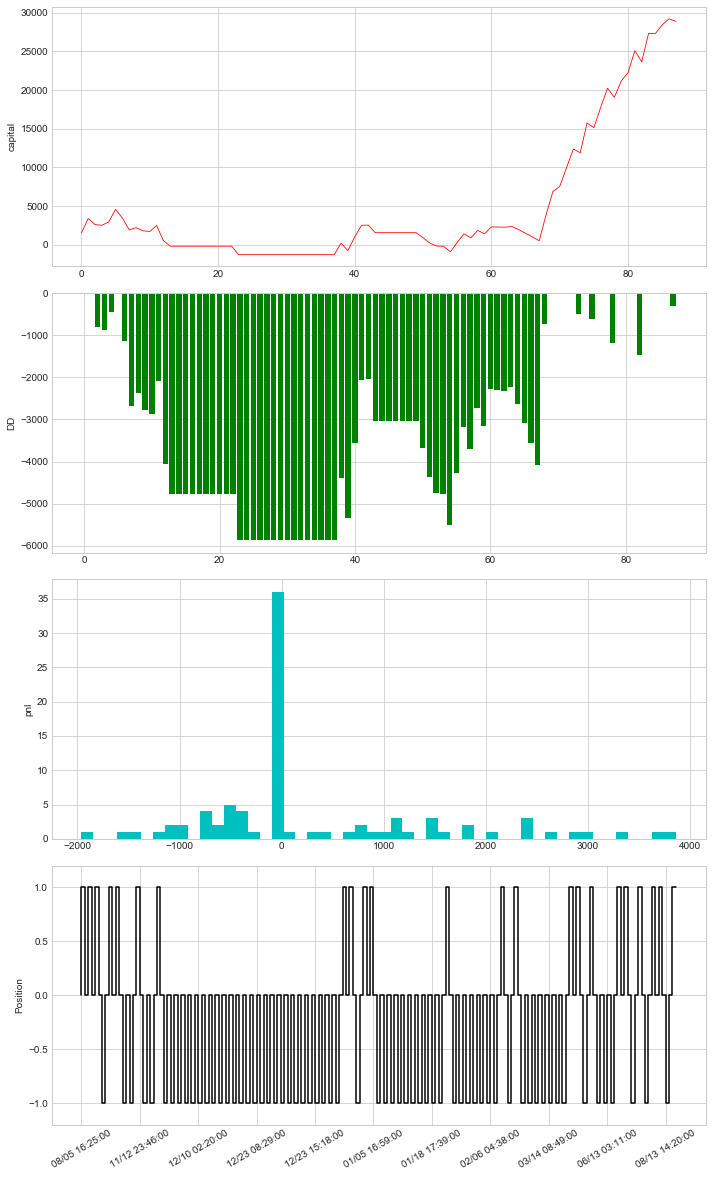

In [244]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()
#回测区间 20170601-20180820
#止损参数：0.06止损，0.12止盈
#ATR 15分钟bar 6 ，据此分1、3、4、5四个仓位等级
#唐安奇通道时间50天


2018-08-24 19:51:39.066769	计算按日统计结果
2018-08-24 19:51:39.103771	------------------------------
2018-08-24 19:51:39.103771	首个交易日：	2018-03-10
2018-08-24 19:51:39.103771	最后交易日：	2018-08-20
2018-08-24 19:51:39.103771	总交易日：	164
2018-08-24 19:51:39.103771	盈利交易日	55
2018-08-24 19:51:39.103771	亏损交易日：	31
2018-08-24 19:51:39.103771	起始资金：	100000
2018-08-24 19:51:39.103771	结束资金：	242,007.11
2018-08-24 19:51:39.103771	总收益率：	142.01%
2018-08-24 19:51:39.103771	年化收益：	207.82%
2018-08-24 19:51:39.103771	总盈亏：	142,007.11
2018-08-24 19:51:39.103771	最大回撤: 	-9,589.04
2018-08-24 19:51:39.103771	百分比最大回撤: -5.39%
2018-08-24 19:51:39.103771	总手续费：	4,313.39
2018-08-24 19:51:39.103771	总滑点：	61.5
2018-08-24 19:51:39.103771	总成交金额：	4,313,389.0
2018-08-24 19:51:39.103771	总成交笔数：	39
2018-08-24 19:51:39.103771	日均盈亏：	865.9
2018-08-24 19:51:39.103771	日均手续费：	26.3
2018-08-24 19:51:39.103771	日均滑点：	0.38
2018-08-24 19:51:39.103771	日均成交金额：	26,301.15
2018-08-24 19:51:39.103771	日均成交笔数：	0.24
2018-08-24 19:51:39.103771	日均收益率：	0.54%
2018-08

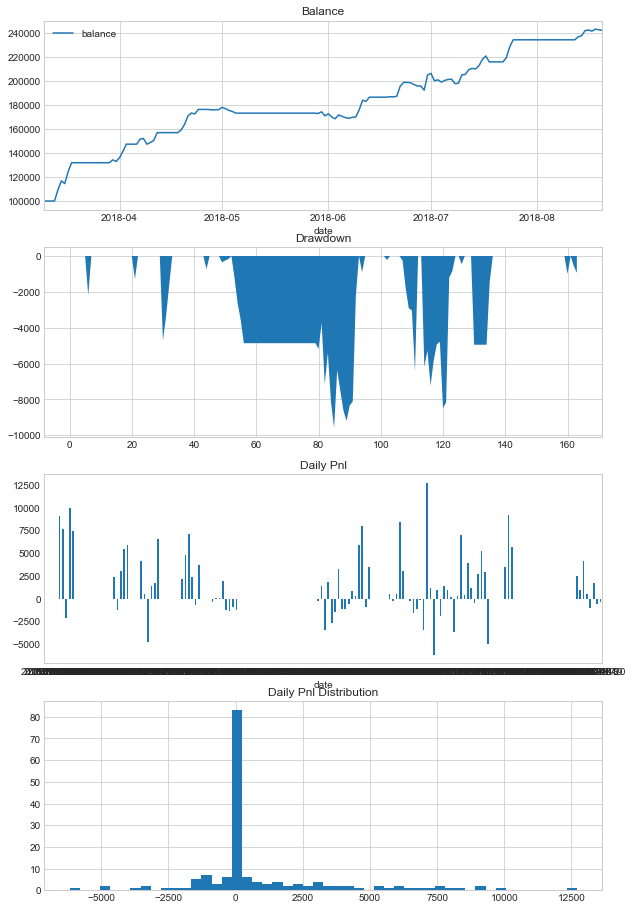

2018-08-24 19:51:40.749865	计算回测结果
2018-08-24 19:51:40.751865	------------------------------
2018-08-24 19:51:40.751865	第一笔交易：	2018-03-15 02:06:00
2018-08-24 19:51:40.751865	最后一笔交易：	2018-08-20 23:59:00
2018-08-24 19:51:40.751865	总交易次数：	20
2018-08-24 19:51:40.751865	总盈亏：	141,909.24
2018-08-24 19:51:40.752865	最大回撤: 	-7,295.25
2018-08-24 19:51:40.752865	平均每笔盈利：	7,095.46
2018-08-24 19:51:40.752865	平均每笔滑点：	3.15
2018-08-24 19:51:40.752865	平均每笔佣金：	220.49
2018-08-24 19:51:40.752865	胜率		70.0%
2018-08-24 19:51:40.752865	盈利交易平均值	11,592.93
2018-08-24 19:51:40.752865	亏损交易平均值	-3,398.63
2018-08-24 19:51:40.752865	盈亏比：	3.41


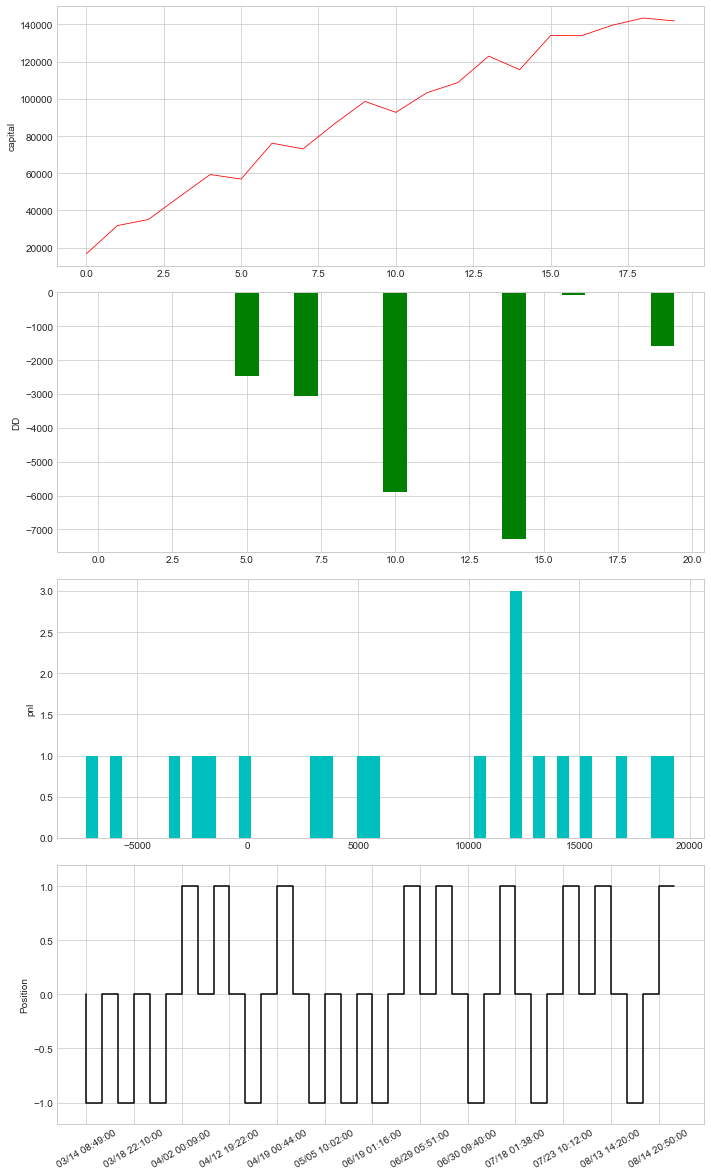

In [169]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

2018-08-24 19:40:04.241027	计算按日统计结果
2018-08-24 19:40:04.274029	------------------------------
2018-08-24 19:40:04.275029	首个交易日：	2018-03-01
2018-08-24 19:40:04.275029	最后交易日：	2018-08-20
2018-08-24 19:40:04.275029	总交易日：	173
2018-08-24 19:40:04.275029	盈利交易日	54
2018-08-24 19:40:04.275029	亏损交易日：	39
2018-08-24 19:40:04.275029	起始资金：	100000
2018-08-24 19:40:04.276029	结束资金：	121,954.55
2018-08-24 19:40:04.276029	总收益率：	21.95%
2018-08-24 19:40:04.276029	年化收益：	30.46%
2018-08-24 19:40:04.276029	总盈亏：	21,954.55
2018-08-24 19:40:04.276029	最大回撤: 	-4,209.95
2018-08-24 19:40:04.276029	百分比最大回撤: -3.38%
2018-08-24 19:40:04.276029	总手续费：	859.75
2018-08-24 19:40:04.276029	总滑点：	12.3
2018-08-24 19:40:04.276029	总成交金额：	859,750.2
2018-08-24 19:40:04.276029	总成交笔数：	39
2018-08-24 19:40:04.276029	日均盈亏：	126.9
2018-08-24 19:40:04.276029	日均手续费：	4.97
2018-08-24 19:40:04.276029	日均滑点：	0.07
2018-08-24 19:40:04.276029	日均成交金额：	4,969.65
2018-08-24 19:40:04.276029	日均成交笔数：	0.23
2018-08-24 19:40:04.276029	日均收益率：	0.11%
2018-08-24 19:4

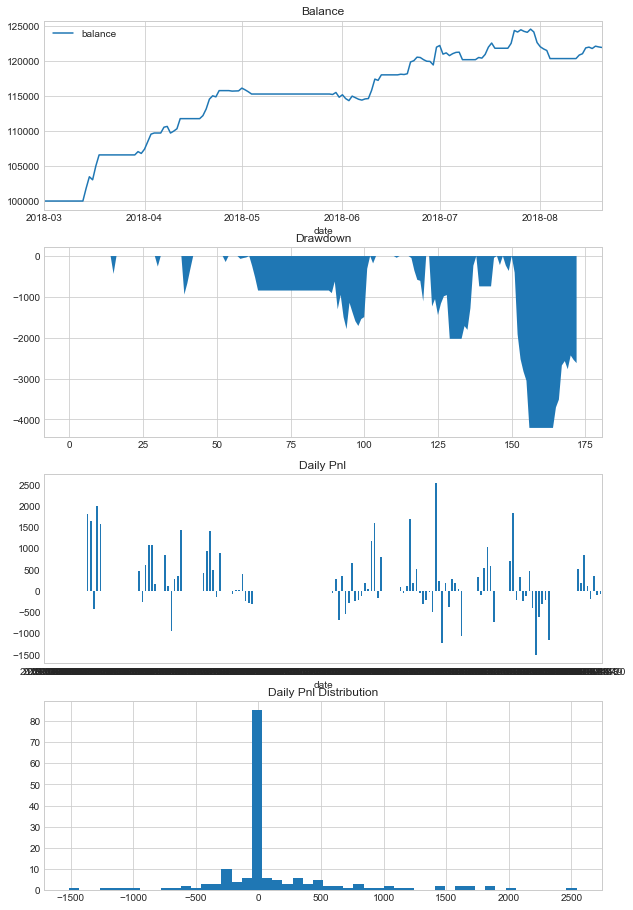

2018-08-24 19:40:06.457154	计算回测结果
2018-08-24 19:40:06.460154	------------------------------
2018-08-24 19:40:06.460154	第一笔交易：	2018-03-15 05:12:00
2018-08-24 19:40:06.460154	最后一笔交易：	2018-08-20 23:59:00
2018-08-24 19:40:06.460154	总交易次数：	20
2018-08-24 19:40:06.460154	总盈亏：	21,934.97
2018-08-24 19:40:06.460154	最大回撤: 	-2,708.3
2018-08-24 19:40:06.460154	平均每笔盈利：	1,096.75
2018-08-24 19:40:06.460154	平均每笔滑点：	0.63
2018-08-24 19:40:06.460154	平均每笔佣金：	43.95
2018-08-24 19:40:06.460154	胜率		60.0%
2018-08-24 19:40:06.460154	盈利交易平均值	2,363.98
2018-08-24 19:40:06.460154	亏损交易平均值	-804.1
2018-08-24 19:40:06.460154	盈亏比：	2.94


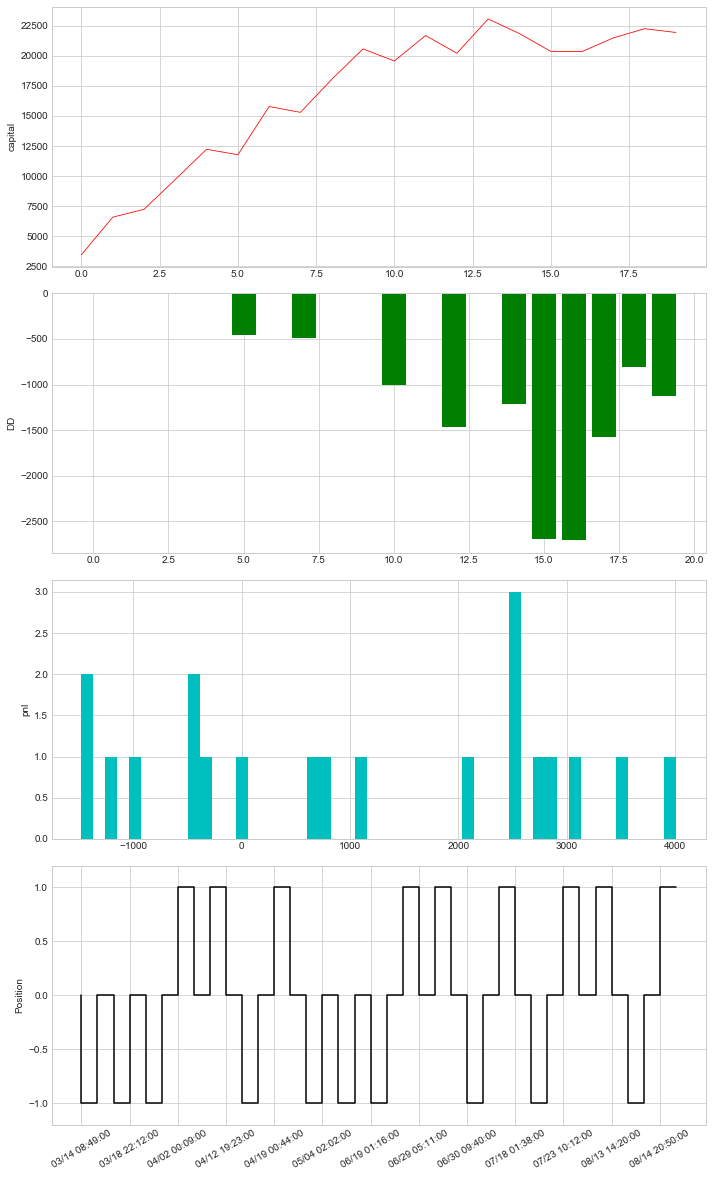

In [142]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

# 回测结果